# What is this?
in this part I gonna see how much my model doing well. 

we learn here how to normalize our data, add layer to our model.

check model characteristic measurments like "RecaLL"

And more important is that we finally see binary classification in action

In [ ]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
#  Import libs that we need /  be sure you read a bit about them


import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# these are pandas configs
# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# nothing to attention. just config keras float data type
tf.keras.backend.set_floatx('float32')

In [ ]:
# like last verions we just get our row data from csv/  you can download it from my repo

# get all data
data_frame = pd.read_csv("/content/drive/MyDrive/bitcoin_ticker.csv")
 # shuffle the data_frame before doing anything
data_frame = data_frame.reindex(np.random.permutation(data_frame.index))
# get btc data
data_frame = data_frame.loc[(data_frame['rpt_key'] == 'btc_usd')]
# in next version we dont delete this columns at all. we del these here just to be simple for now
del data_frame["datetime_id"]
del data_frame["date_id"]
del data_frame["created_at"]
del data_frame["updated_at"]
del data_frame["market"]
del data_frame["rpt_key"]
#  a big BUUUUT : we are not gonna use scale factor  we just gonna use z-score you will see
# first let me build train and test dataset
# build train data frame and test data frame
train_last_index = int(len(data_frame) * 0.80)
train_df, test_df = data_frame.iloc[0:train_last_index], data_frame.iloc[train_last_index:len(data_frame) + 1] # i just add +1 to make sure wont get anny train data in test data
 # shuffle the train_df after doing sepration
train_df = train_df.reindex(np.random.permutation(train_df.index))
train_df.head()

,last,diff_24h,diff_per_24h,bid,ask,low,high,volume
410644,2653.0,2608.6,1.7,2653.0,2659.4,2576.0,2750.0,1009.3
154864,3006.2,2878.3,4.4,3004.9,3008.0,2880.0,3048.0,2825.2
86444,2960.1,2747.3,7.7,2960.2,2963.1,2684.3,3095.0,3990.6
1534,2403.4,2239.0,7.3,2403.4,2403.9,2129.8,2423.0,5136.5
497543,2548.0,2616.5,-2.6,2544.5,2548.0,2540.0,2639.5,10450.3


#SO What is the z-score that i call it "Big But" loudly 

z-score convert our mutiple ranged data. to a flat and goodboy data
so we can use it easily. more than you think.

# we call it normalization babe

In [ ]:
# Calculate the Z-scores of each column in the training set and
# write those Z-scores into a new pandas DataFrame named train_df_norm.
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Calculate the Z-scores of each column in the test set and
# write those Z-scores into a new pandas DataFrame named test_df_norm.
test_df_mean = test_df.mean()
test_df_std  = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

so here. we just put a condition:
if tht "last" price value is greather than 2300 we add  "last_value_is_high" as a boolean type and set it to 1 ( true ) / else we set this new column value to 0 ( false )

In [ ]:
# We arbitrarily set the threshold to 2300, which is 
# the 80th percentile for btc last value.  Every neighborhood
# with a last price above 2300 will be labeled 1, 
# and all other neighborhoods will be labeled 0.
threshold = 2500
train_df_norm["last_value_is_high"] = (train_df["last"] > threshold).astype(float)
test_df_norm["last_value_is_high"] = (test_df["last"] > threshold).astype(float) 

This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. The transformations (collected in feature_layer) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model.
( i just copied this code cell and use its own definition to descripe the code job )

In [ ]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

diff24h = tf.feature_column.numeric_column("diff_24h")
feature_columns.append(diff24h)

bid = tf.feature_column.numeric_column("bid")
feature_columns.append(bid)

ask = tf.feature_column.numeric_column("ask")
feature_columns.append(ask)

low = tf.feature_column.numeric_column("low")
feature_columns.append(low)

high = tf.feature_column.numeric_column("high")
feature_columns.append(high)

volume = tf.feature_column.numeric_column("volume")
feature_columns.append(volume)

# add feature  columns as layers for our model
feature_layer = layers.DenseFeatures(feature_columns)

# Print the first 3 and last 3 rows of the feature_layer's output when applied
# to train_df_norm:
feature_layer(dict(train_df_norm))

<tf.Tensor: shape=(100350, 6), dtype=float32, numpy=
array([[ 0.16593446,  0.15368643, -0.107728  ,  0.18057564,  0.25963303,
        -0.99059397],
       [ 2.3348088 ,  2.3306978 ,  1.4879903 ,  1.9626656 ,  2.2901564 ,
        -0.71966565],
       [ 2.0553696 ,  2.0541174 ,  0.71290344,  2.2437334 ,  0.9828304 ,
        -0.5457932 ],
       ...,
       [-0.77243644, -0.7617323 , -1.1935238 , -1.1427158 , -0.85224867,
        -0.02429852],
       [ 0.3942272 ,  0.30450347,  0.3422766 , -0.07830582,  0.28628454,
        -0.94462556],
       [ 0.31140965,  0.33531025,  0.32814002,  0.62304825,  0.6908663 ,
        -0.7554366 ]], dtype=float32)>

>> and like last two train we define our function. but with a little difference.
check and find it !

In [ ]:
def create_model(my_learning_rate, feature_layer, my_metrics):
  """Create and compile a simple classification model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the feature layer (the list of features and how they are represented)
  # to the model.
  model.add(feature_layer)

  # Funnel the regression value through a sigmoid function.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression. => "BinaryCrossentropy"   
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist  

>> like past we define our plot functions

In [ ]:
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

 copied purely from google source:
# Invoke the creating, training, and plotting functions
The following code cell calls specify the hyperparameters, and then invokes the functions to create and train the model, and then to plot the results.

=====================================================================
#  this  Part we calculate our model accuracy / make sure you read about that

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


1004/1004 [==============================] - 2s 2ms/step - loss: 0.3483 - accuracy: 0.9339
Epoch 2/20
1004/1004 [==============================] - 2s 2ms/step - loss: 0.2110 - accuracy: 0.9562
Epoch 3/20
1004/1004 [==============================] - 2s 2ms/step - loss: 0.1505 - accuracy: 0.9628
Epoch 4/20
1004/1004 [==============================] - 2s 2ms/step - loss: 0.1202 - accuracy: 0.9719
Epoch 5/20
1004/1004 [==============================] - 2s 2ms/step - loss: 0.1027 - accuracy: 0.9748
Epoch 6/20
1004/1004 [==============================] - 2s 2ms/step - loss: 0.0914 - accuracy: 0.9768
Epoch 7/20
1004/1004 [==============================] - 2s 2ms/step - loss: 0.0833 - accuracy: 0.9783
Epoch 8/20
1004/1004 [==============================] - 2s 2ms/step - loss: 0.0771 - accuracy: 0.9796
Epoch 9/20
1004/1004 [==============================] - 2s 2ms/step - loss: 0.0721 - accuracy: 0.9804
Epoch 10/20
1004/1004 [==============================] - 2s 2ms/step - loss: 0.0682 - accurac

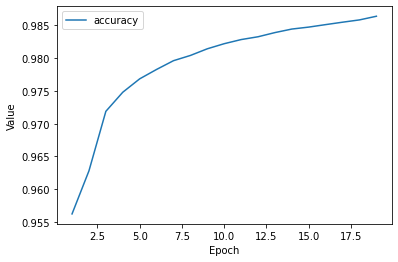

In [ ]:


# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "last_value_is_high"
classification_threshold = 0.35

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

# sooo let see our model in action. lets test it with test set


In [ ]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

251/251 [==============================] - 1s 2ms/step - loss: 0.0478 - accuracy: 0.9847


[0.047798678278923035, 0.9846938848495483]

#ok!! 98% percent. looks really good.
# but, is it realy true? 
lets chalenge our model with Adding precision and recall as metrics

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


1004/1004 [==============================] - 3s 2ms/step - loss: 0.4201 - accuracy: 0.5685 - precision: 1.0000 - recall: 0.4157
Epoch 2/20
1004/1004 [==============================] - 2s 2ms/step - loss: 0.2357 - accuracy: 0.7644 - precision: 1.0000 - recall: 0.6810
Epoch 3/20
1004/1004 [==============================] - 2s 2ms/step - loss: 0.1640 - accuracy: 0.8438 - precision: 1.0000 - recall: 0.7885
Epoch 4/20
1004/1004 [==============================] - 2s 2ms/step - loss: 0.1290 - accuracy: 0.8798 - precision: 1.0000 - recall: 0.8372
Epoch 5/20
1004/1004 [==============================] - 2s 2ms/step - loss: 0.1084 - accuracy: 0.9027 - precision: 1.0000 - recall: 0.8682
Epoch 6/20
1004/1004 [==============================] - 2s 2ms/step - loss: 0.0951 - accuracy: 0.9169 - precision: 1.0000 - recall: 0.8874
Epoch 7/20
1004/1004 [==============================] - 2s 2ms/step - loss: 0.0858 - accuracy: 0.9256 - precision: 1.0000 - recall: 0.8992
Epoch 8/20
1004/1004 [================

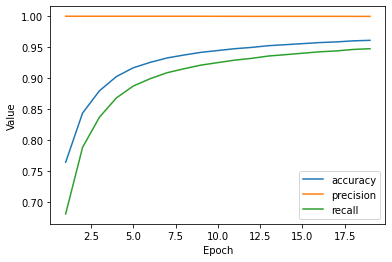

In [ ]:

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.35  # =>> you can change it to see different result
label_name = "last_value_is_high"

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)


# The new graphs suggest that precision and recall are 
# somewhat in conflict. That is, improvements to one of
# those metrics may hurt the other metric.